In [1]:
import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from keras import layers, models

In [2]:
# Load the cats vs dogs dataset
(train_ds, validation_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
# Data preprocessing
IMG_SIZE = 160
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# 3. Preprocessing (resize + normalize)
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

# 4. Data‐Augmentation pipeline
data_augmentation = tf.keras.Sequential([
    # Randomly crop somewhere between 60–100% of the image, then resize back to IMG_SIZE
    tf.keras.layers.RandomCrop(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1, 0.1),
])

# 5. Prepare training dataset
train_ds = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)   # resize & normalize
    .cache()                                        # cache preprocessed images
    .shuffle(1000)                                  # shuffle buffer
    .map(lambda x, y: (data_augmentation(x, training=True), y),
         num_parallel_calls=AUTOTUNE)               # apply augmentation each epoch
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# 6. Prepare validation dataset (no augmentation)
validation_ds = (
    validation_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [4]:
model = keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [5]:
model = models.Sequential([
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [6]:
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [8]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/20


2025-06-19 12:17:24.174506: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


582/582 ━━━━━━━━━━━━━━━━━━━━ 479s 809ms/step - accuracy: 0.8929 - loss: 0.2521 - val_accuracy: 0.8362 - val_loss: 1.7091
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 556s 955ms/step - accuracy: 0.9400 - loss: 0.1560 - val_accuracy: 0.7403 - val_loss: 2.6914
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.9425 - loss: 0.1429 - val_accuracy: 0.8762 - val_loss: 1.5063
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 491s 843ms/step - accuracy: 0.9538 - loss: 0.1220 - val_accuracy: 0.7285 - val_loss: 4.2329
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 468s 803ms/step - accuracy: 0.9578 - loss: 0.1100 - val_accuracy: 0.6993 - val_loss: 0.5459
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 549s 943ms/step - accuracy: 0.9620 - loss: 0.0986 - val_accuracy: 0.8547 - val_loss: 0.9702
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 697s 1s/step - accuracy: 0.9647 - loss: 0.0977 - val_accuracy: 0.9209 - val_loss: 0.5389
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.9668 - loss: 0.0926 - val_

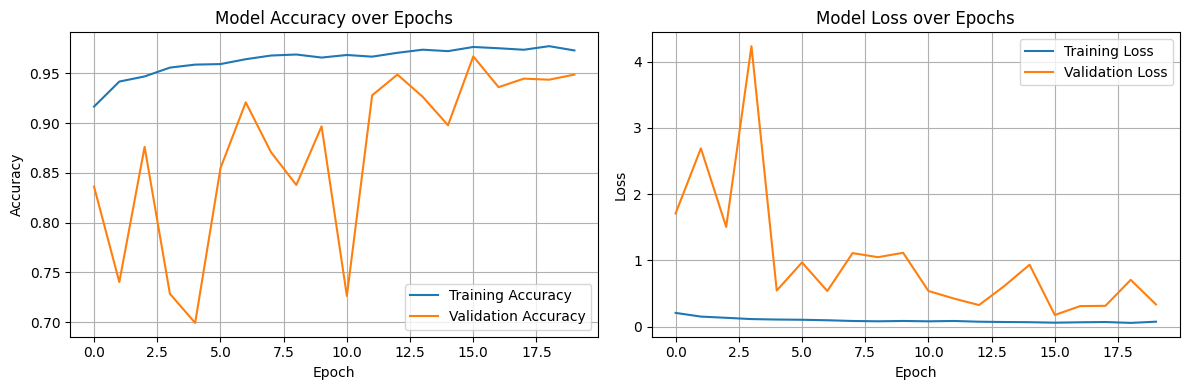


Final Training Metrics:
Training Accuracy: 0.9731
Validation Accuracy: 0.9488
Training Loss: 0.0761
Validation Loss: 0.3365


In [9]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print('\nFinal Training Metrics:')
print(f'Training Accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.4f}')
print(f'Training Loss: {history.history["loss"][-1]:.4f}')
print(f'Validation Loss: {history.history["val_loss"][-1]:.4f}')

Sample predictions on validation dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


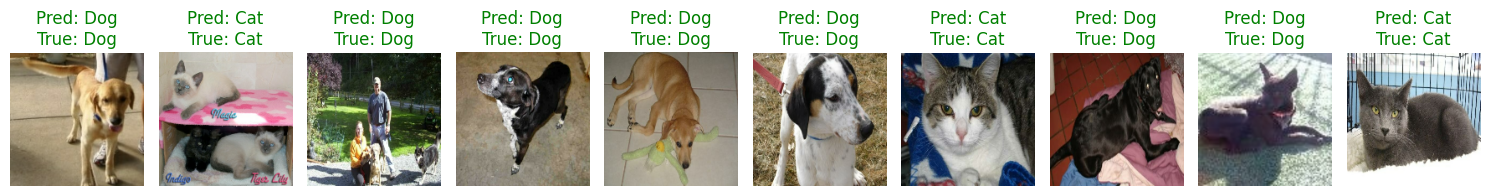

In [10]:
# Visualize some predictions
def plot_predictions(dataset, num_images=5):
    # Get a batch of images
    images, labels = next(iter(dataset.unbatch().batch(num_images)))

    # Make predictions
    predictions = model.predict(images)

    # Plot the images and predictions
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        pred_label = "Dog" if predictions[i] > 0.5 else "Cat"
        true_label = "Dog" if labels[i] == 1 else "Cat"
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on validation dataset
print("Sample predictions on validation dataset:")
plot_predictions(validation_ds, 10)